In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import pymysql
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pygam import LinearGAM, s, f
import os
import warnings
warnings.filterwarnings(action='ignore') 

In [3]:
def pickleLoad(file):
    if os.path.isfile(file):        
        with open(file,"rb") as fr:
            dataframe = pickle.load(fr)
        return dataframe
    else:  
        %run -i './getTrainTestSet/getTrainTestSet.py' 

In [4]:
# load train, test set data

X_train = pickleLoad('./dataset/dataset_mean/X_train.pkl')
X_test = pickleLoad('./dataset/dataset_mean/X_test.pkl')
y_train = pickleLoad('./dataset/dataset_mean/y_train.pkl')
y_test = pickleLoad('./dataset/dataset_mean/y_test.pkl')
ccsi = pickleLoad('./dataset/dataset_mean/ccsi.pkl')
predictors = pickleLoad('./dataset/dataset_mean/predictors.pkl')

* data preprocessing(standard scaling)

In [6]:
# 변수 스케일링
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test= scaler.transform(X_test)

### model 1. multiple linear regression

* 10-fold CV

In [7]:
model_lr = LinearRegression()
scores = cross_val_score(model_lr, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
rmse_linearRegressionCV = np.sqrt(-scores)
rmse_lravg = rmse_linearRegressionCV.mean()
rmse_lrstd = rmse_linearRegressionCV.std()

In [8]:
print(" 10-fold cv RMSE: ", rmse_linearRegressionCV)
print("최종 CV RMSE = ", rmse_lravg)

 10-fold cv RMSE:  [3.62311388 2.94033541 6.89129922 6.82041626 2.22932892 2.86554892
 3.64621428 0.59432644 3.96861431 2.04639006]
최종 CV RMSE =  3.5625587704543866


### model 2: Random Forest

In [9]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [10]:
# CV
rmse_randomforest, parameters_randomforest = [], []
numOfEstimators = np.power(2, [3,4,5,6])
maxFeatures = [1,2,3,4,5]
for i in maxFeatures:
    for j in numOfEstimators:
        # parameter search
        model_forest = RandomForestRegressor(max_features = i, n_estimators = j, warm_start = True, random_state = 23)
        parameters_randomforest.append(model_forest.get_params)
        # 10-fold CV
        scores = cross_val_score(model_forest, X_train, y_train, cv = k_fold, scoring = 'neg_mean_squared_error')
        rmse_randomforest.append(np.sqrt(-scores))
    

In [11]:
def getCVResult(rmse_list, model_num):
    cv_rmse =  rmse_list[model_num - 1].mean()
    std = rmse_list[model_num - 1].std()

    return cv_rmse, std

In [12]:
rmse_list, std_list = [], []
for i in range(1,21):
    cv_rmse, std = getCVResult(rmse_randomforest, i)
    rmse_list.append(cv_rmse)
    std_list.append(std)
    print(i, cv_rmse, std)
    

1 4.660100984067306 2.138110893591565
2 4.287166837279387 2.395895644434318
3 4.1861309464285075 2.335970721782587
4 4.153820152685928 2.422839576460097
5 4.315631398276771 2.1524511485066666
6 4.20780996817912 2.016434701274733
7 4.241879061432306 2.165447428429407
8 3.9667316695120194 2.3450667408047563
9 3.9397325755653334 2.2282766004312227
10 3.6059013622626863 2.21440321884522
11 3.6928651911294645 2.205312212268793
12 3.7088505267691025 2.289875759236912
13 3.7805945864211 2.263386368778752
14 3.6084771603682975 2.2825145050826845
15 3.66631510457497 2.263755362030466
16 3.6252784657148545 2.3340010349570197
17 4.064938125074813 1.9003613740058118
18 3.64204475124277 2.0347201777689192
19 3.7707927572336644 2.0165671997373766
20 3.732786217309915 2.1973262561527713


#### final random forest model selection

In [13]:
rmse_list.index(min(rmse_list))

9

model 후보 1~20번 중에, 10번모델이 가장 낮은 rmse 평균값을 갖고있음을 확인할 수 있다.

따라서, 10번 모델을 랜덤포레스트 대표모델로 활용하고자 한다.

In [14]:
# 대표 모델의 파라미터
parameters_randomforest[rmse_list.index(min(rmse_list))]

<bound method BaseEstimator.get_params of RandomForestRegressor(max_features=3, n_estimators=16, random_state=23,
                      warm_start=True)>

In [15]:
# 대표 모델의 평균 rmse와 std
rmse_forestavg = rmse_list[rmse_list.index(min(rmse_list))]
rmse_foreststd = std_list[rmse_list.index(min(rmse_list))]

In [16]:
# 대표 모델의 10-fold cv
rmse_randomforestCV = rmse_randomforest[rmse_list.index(min(rmse_list))]
rmse_randomforestCV

array([1.89140944, 2.13107587, 1.84590552, 7.07861326, 3.81807993,
       8.08683875, 1.6572933 , 2.68051782, 2.03320819, 4.83607153])

In [17]:
print(" 10-fold cv RMSE: ", rmse_randomforestCV)
print("최종 CV RMSE = ", rmse_forestavg)

 10-fold cv RMSE:  [1.89140944 2.13107587 1.84590552 7.07861326 3.81807993 8.08683875
 1.6572933  2.68051782 2.03320819 4.83607153]
최종 CV RMSE =  3.6059013622626863


### model 3: GAM

In [59]:
X_train_df = pd.DataFrame(X_train, columns = ['keyword1', 'keyword2', 'keyword3', 'keyword4', 'keyword5', 'google', 'naver'])
y_train_df = np.array(y_train)
y_train_df = pd.DataFrame(y_train_df)

In [60]:
# CV
rmse_gam, parameters_gam = [], []
np.random.seed(1)
lams = np.random.rand(100, 7) # random points on [0, 1], with shape (100, 7)
lams = lams * 6 - 3 # shift values to -3, 3
lams = 10 ** lams # transforms values to 1e-3, 

K=10
for k in range(K):
    if k < 3:
        val_ind = (range(4 * k, 4 * k + 4))
    else:
        val_ind = (range(5 * (k-1)+1, 5 * (k-1)+6))
    X_train2 = X_train_df.drop(val_ind).to_numpy()
    y_train2 = y_train_df.drop(val_ind).to_numpy()
    X_val = X_train_df.loc[val_ind, :].to_numpy()
    y_val = y_train_df.loc[val_ind, :].to_numpy()
    # parameter search
    model_gam =  LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)+ s(6)).gridsearch(X_train2, y_train2, lam=lams)
    parameters_gam.append(model_gam.get_params)
    y_hat = model_gam.predict(X_val)
    scores = mean_squared_error(y_val, y_hat)
    rmse_gam.append(np.sqrt(scores))
    

100% (100 of 100) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (100 of 100) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (100 of 100) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (100 of 100) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (100 of 100) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (100 of 100) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (100 of 100) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (100 of 100) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (100 of 100) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (100 of 100) |######################| Elapsed Time: 0:00:05 Time:  0:00:05


In [61]:
rmse_gamavg = np.mean(rmse_gam)
rmse_gamstd = np.std(rmse_gam)
print(" 10-fold cv RMSE: ", rmse_gam)
print("최종 CV RMSE = ", rmse_gamavg)

 10-fold cv RMSE:  [4.761285365438659, 8.341046422205833, 4.253105602132854, 6.3986141735342255, 9.473145883144749, 7.769099719965774, 5.040161589006731, 3.4517817779863202, 5.129498276349468, 8.033509658521345]
최종 CV RMSE =  6.265124846828596


### model 4: Lasso Regression

In [26]:
# CV
rmse_lasso, parameters_lasso = [], []
alpha = [10, 1, 0.1, 0.01, 0.001]
for i in alpha:
    # parameter search
    model_lasso = Lasso(alpha = i, random_state = 23)
    parameters_lasso.append(model_lasso.get_params)
    # 10-fold CV
    scores = cross_val_score(model_lasso, X_train, y_train, cv = k_fold, scoring = 'neg_mean_squared_error')
    rmse_lasso.append(np.sqrt(-scores))
    

In [27]:
rmse_list, std_list = [], []
for i in range(1, 6):
    cv_rmse, std = getCVResult(rmse_lasso, i)
    rmse_list.append(cv_rmse)
    std_list.append(std)
    print(i, cv_rmse, std)
    

1 7.517047407555718 3.02194391232923
2 3.639095890664785 1.7107950295218877
3 3.680305780548256 1.7403992794164995
4 3.7180365572854526 1.652340753555634
5 3.724711460380604 1.6455718657658402


#### final lasso linear regression model selection

In [28]:
rmse_list.index(min(rmse_list))

1

model 후보 1~5번 중에, 2번모델이 가장 낮은 rmse 평균값을 갖고 있음을 확인할 수 있다.

따라서, 2번 모델을 라쏘 회귀 대표모델로 활용하고자 한다.

In [29]:
# 대표 모델의 파라미터
parameters_lasso[rmse_list.index(min(rmse_list))]

<bound method BaseEstimator.get_params of Lasso(alpha=1, random_state=23)>

In [30]:
# 대표 모델의 평균 rmse와 std
rmse_lassoavg = rmse_list[rmse_list.index(min(rmse_list))]
rmse_lassostd = std_list[rmse_list.index(min(rmse_list))]

In [31]:
# 대표 모델의 10-fold cv
rmse_lassoCV = rmse_lasso[rmse_list.index(min(rmse_list))]
rmse_lassoCV 

array([1.79053645, 3.22804947, 2.81972063, 7.79911206, 4.29119618,
       4.67420667, 2.5433981 , 4.24969463, 1.49042231, 3.50462241])

###  Model간 CV RMSE 비교

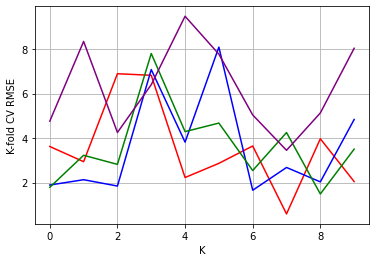

In [32]:
plt.plot(rmse_linearRegressionCV, color = 'red', label = 'Linear Regression')
plt.plot(rmse_randomforestCV, color = 'blue', label = 'Random Forest')
plt.plot(rmse_lassoCV, color = 'green', label = 'Lasso Linear Regression')
plt.plot(rmse_gam, color = 'purple', label = 'Lasso Linear Regression')
plt.xlabel("K")
plt.ylabel("K-fold CV RMSE")
plt.grid(True)

In [33]:
print(rmse_lravg, rmse_forestavg, rmse_lassoavg, rmse_gamavg)

3.5625587704543866 3.6059013622626863 3.639095890664785 6.265124846828596


## T-test

In [34]:
def tTest(rmse1, rmse2):
    mean = (rmse1 - rmse2).mean()
    sd = (rmse1 - rmse2).std()
    t_statistic = mean / (sd / np.sqrt(10)) 
    return t_statistic

**H0**: linear regression model의 rmse = Random Forest model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [35]:
mean = np.average(rmse_linearRegressionCV - rmse_randomforestCV)
sd = (rmse_linearRegressionCV - rmse_randomforestCV).std()
print('평균: ', mean)
tTest(rmse_linearRegressionCV, rmse_randomforestCV)

평균:  -0.04334259180830071


-0.04883236135535948

t_0.05,9 = 1.844 <br>
t_0.025,9 = 2.262 <br><br>

유의수준 0.025에서 귀무가설이 기각되지 않는다. 따라서, linear regression model과 Random forest model의 성능에는 차이가 없다.


**H0**: linear regression model의 rmse = Lasso linear regression model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [36]:
mean = np.average(rmse_linearRegressionCV - rmse_lassoCV)
sd = (rmse_linearRegressionCV - rmse_lassoCV).std()
print('평균: ', mean)
tTest(rmse_linearRegressionCV, rmse_lassoCV) 

평균:  -0.07653712021039864


-0.1068736629495559

t_0.05,9 = 1.844 <br>
t_0.025,9 = 2.262 <br><br>

유의수준 0.025에서 귀무가설이 기각되지않는다. 따라서, linear regression model과 Lasso linear regression model의 성능에는 차이가 없다.

**H0**: Random Forest model의 rmse = Lasso linear regression model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [37]:
mean = np.average(rmse_randomforestCV - rmse_lassoCV)
sd = (rmse_randomforestCV - rmse_lassoCV).std()
print('평균: ', mean)
tTest(rmse_randomforestCV, rmse_lassoCV)

평균:  -0.03319452840209787


-0.07449630512451616

t_0.05,9 = 1.844 <br>
t_0.025,9 = 2.262 <br><br>

유의수준 0.025에서 귀무가설이 기각되지않는다. 따라서, random forest model과 Lasso linear regression model의 성능에는 차이가 없다.

**H0**: linear regression model의 rmse = Generalized additive model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>

**H1**: 두 모델의 성능에 차이가 있다.

In [38]:
mean = np.average(rmse_linearRegressionCV - rmse_gam)
sd = (rmse_linearRegressionCV - rmse_gam).std()
print('평균: ', mean)
tTest(rmse_linearRegressionCV, rmse_gam)

평균:  -2.70256607637421


-2.874719765496354

t_0.05,9 = 1.844 <br>
t_0.025,9 = 2.262 <br><br>

유의수준 0.05에서 귀무가설이 기각된다. 따라서, linear regression model과 Generalized additive model의 성능에는 차이가 있다. 평균값이 음수값이 나왔으므로 linear regression model의 rmse가 더 작아고 판단된다. 따라서 linear regression model의 성능이 더 좋다고 할 수 있다.

**H0**:  Random Forest model의 rmse = Generalized additive model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [39]:
mean = np.average(rmse_randomforestCV - rmse_gam)
sd = (rmse_randomforestCV - rmse_gam).std()
print('평균: ', mean)
tTest(rmse_randomforestCV, rmse_gam)

평균:  -2.659223484565909


-3.9092603738698886

t_0.05,9 = 1.844 <br>
t_0.025,9 = 2.262 <br><br>

유의수준 0.05에서 귀무가설이 기각된다. 따라서, Random Forest model과 Generalized additive model의 성능에는 차이가 있다. 평균값이 음수값이 나왔으므로 Random Forest model의 rmse가 더 작아고 판단된다. 따라서 Random Forest model의 성능이 더 좋다고 할 수 있다.

**H0**: Lasso linear regression model의 rmse = Generalized additive model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [55]:
mean = np.average(rmse_gam - rmse_lassoCV)
sd = (rmse_gam - rmse_lassoCV).std()
print('평균: ', mean)
tTest(rmse_gam, rmse_lassoCV)

평균:  2.626028956163811


3.827243983117924

t_0.05,9 = 1.844 <br>
t_0.025,9 = 2.262 <br><br>

유의수준 0.05에서 귀무가설이 기각된다. 따라서, Lasso linear regression model과 Generalized additive model의 성능에는 차이가 있다. 평균값이 양수값이 나왔으므로 Lasso linear regression model의 rmse가 더 작아고 판단된다. 따라서 Lasso linear regression model의 성능이 더 좋다고 할 수 있다.

결론적으로, GAM은 다른 3개의 모델에 비해 성능이 떨어진다. 다른 3개의 모델의 성능은 차이가 있지 않으므로 모델의 해석력이 좋은 linear regression model을 사용하고자 한다.

## Testing

In [41]:
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test) # y_pred: test set을 넣어서 얻은 예측 값

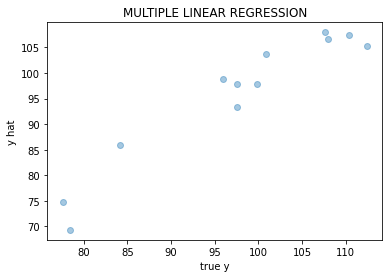

In [42]:
# test set에 대한 실제값과 예측 값의 추세 확인
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("true y")
plt.ylabel("y hat")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

* model evaluating

In [43]:
print("R square: ", model_lr.score(X_train, y_train))
print("training RMSE: ", np.sqrt(mean_squared_error(y_train, model_lr.predict(X_train))))
print("test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

R square:  0.8369693796447781
training RMSE:  3.2420364888857653
test RMSE:  4.006386320440263


## Step5. Visulization
### weekly record 예측하기(weekly CCSI)

In [44]:
X = scaler.transform(predictors.loc[:, ['keyword1', 'keyword2', 'keyword3', 'keyword4', 'keyword5', 'google', 'naver']])

In [45]:
# weekly 레코드들을 예측모델에 집어넣어, 각 레코드에 대한 예측값 얻음
pred_ccsi = model_lr.predict(X)

In [46]:
# tmp = pd.merge(predictors, ccsi).drop(['id'], axis=1)
tmp = pd.merge(predictors, ccsi)
tmp['pred'] = pred_ccsi
tmp.head()

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver,id,ccsi,pred
0,2016,1,4,825,419,437,588,168,53.0,26.05846,91,99.5,104.547157
1,2016,1,11,770,348,351,388,182,58.0,25.16599,91,99.5,100.488620
2,2016,1,18,918,422,441,363,147,74.0,27.38639,91,99.5,92.076754
3,2016,1,25,1067,425,567,393,148,59.0,24.72622,91,99.5,87.973095
4,2016,2,1,899,341,485,297,110,63.0,23.01888,92,97.2,91.018064


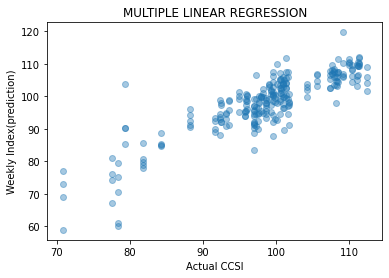

In [48]:
# true와 pred의 추세 확인
plt.scatter(tmp['ccsi'], tmp['pred'], alpha=0.4)
plt.xlabel("Actual CCSI")
plt.ylabel("Weekly Index(prediction)")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

In [49]:
# weekly별 단기지표 값에 대한 MSE
print("RMSE about weekly CCSI: ", np.sqrt(mean_squared_error(tmp['ccsi'], tmp['pred'])))

RMSE about weekly CCSI:  4.792839493297525


### visaulization
* 시계열 그래프

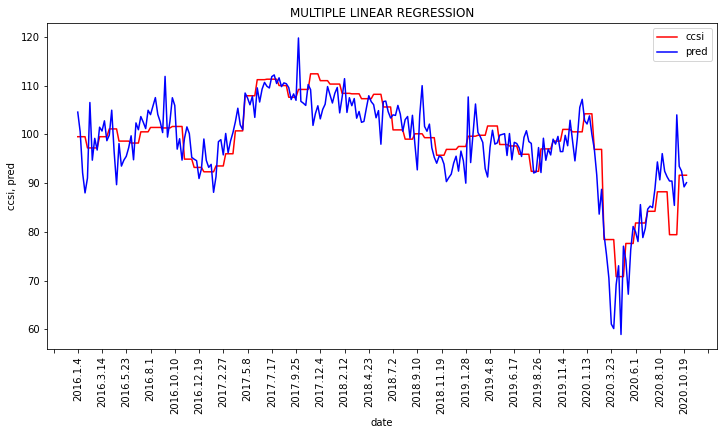

In [50]:
# 시계열 그래프를 그리기위해, 날짜 column 생성
tmp['date'] = tmp[['year', 'month', 'day']].apply(lambda x: '.'.join(map(str, x)), axis=1)

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
plt.plot(tmp['date'], tmp['pred'], color = 'blue', label = 'pred')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(90)
plt.title("MULTIPLE LINEAR REGRESSION")
plt.legend()
plt.show()

* moving avg 시계열 그래프

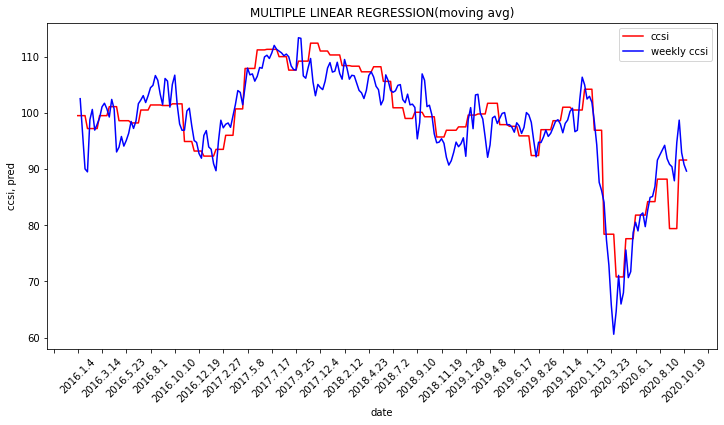

In [51]:
rolling = pd.Series.rolling(tmp['pred'], window = 2, center = False).mean()

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
rolling.plot(color = 'blue', label = 'weekly ccsi')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
plt.title("MULTIPLE LINEAR REGRESSION(moving avg)")
plt.legend()
plt.show()

2주 간의 단기 지표들을 평균낸 값을 weekly CCSI로 활용하고자함. <br>
시각화 결과, 주간 레코드에 대한 예측 결과를 바로 활용하는 것 보다 2주 간의 예측 결과 평균을 활용하는 것이 덜 들쑥날쑥하다.

## Step6. Develop weekly CCSI(주간 경기선행지수)

In [52]:
weekly_CLI = []
for i in range(len(tmp)):
    if i == 0 :
        cli = tmp.pred.iloc[i]
        weekly_CLI.append(cli)
        continue
    
    cli = (tmp.pred.iloc[i-1] + tmp.pred.iloc[i]) / 2
    weekly_CLI.append(cli)
    
tmp['weeklyCLI'] = weekly_CLI
tmp

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver,id,ccsi,pred,date,weeklyCLI
0,2016,1,4,825,419,437,588,168,53.0,26.05846,91,99.5,104.547157,2016.1.4,104.547157
1,2016,1,11,770,348,351,388,182,58.0,25.16599,91,99.5,100.488620,2016.1.11,102.517889
2,2016,1,18,918,422,441,363,147,74.0,27.38639,91,99.5,92.076754,2016.1.18,96.282687
3,2016,1,25,1067,425,567,393,148,59.0,24.72622,91,99.5,87.973095,2016.1.25,90.024925
4,2016,2,1,899,341,485,297,110,63.0,23.01888,92,97.2,91.018064,2016.2.1,89.495580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2020,9,28,489,90,114,27,78,63.0,25.29102,147,79.4,103.977313,2020.9.28,94.694160
248,2020,10,5,816,183,177,47,78,81.0,28.63240,148,91.6,93.427825,2020.10.5,98.702569
249,2020,10,12,857,199,176,55,91,82.0,26.85177,148,91.6,92.386602,2020.10.12,92.907214
250,2020,10,19,911,155,143,64,129,93.0,27.25273,148,91.6,89.207767,2020.10.19,90.797185
